In [138]:
import os
import glob
import json
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
from tqdm import tqdm
import torch.nn.functional as F
from torchsummary import summary
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, TensorDataset

In [139]:
image_path = "All_Images"
mask_path = "All_Masks"

target_shape = (256, 256)

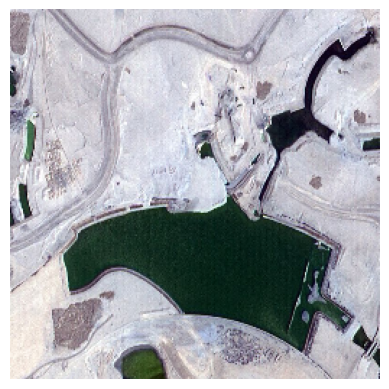

In [141]:
img = cv2.imread("All_Images/Tile 1_image_part_002.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, target_shape)
img = img / 255.0

plt.axis('off')
plt.imshow(img)

In [142]:
def load_data():

    image_files = glob.glob(os.path.join(image_path, "*.jpg"))

    X_train = np.array([ cv2.resize( cv2.cvtColor( cv2.imread(img_path), cv2.COLOR_RGB2BGR ), target_shape ) / 255.0 for img_path in image_files])

    mask_files = glob.glob(os.path.join(mask_path, "*.png"))

    y_train = np.array([ cv2.resize( cv2.cvtColor( cv2.imread(m_path), cv2.COLOR_RGB2BGR ), target_shape ) / 255.0 for m_path in mask_files])

    return X_train, y_train


X_train, y_train = load_data()
X_train.shape, y_train.shape

((71, 256, 256, 3), (71, 256, 256, 3))

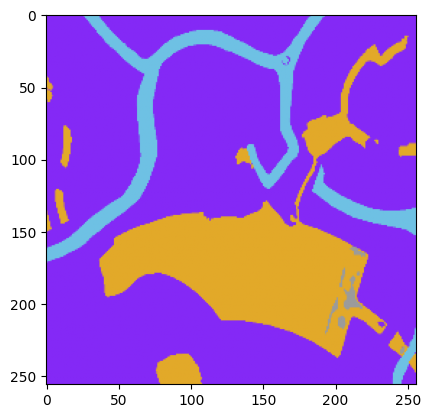

In [143]:
plt.imshow(X_train[0])
plt.imshow(y_train[0])
plt.show()

In [145]:


def crop_and_concat(encoder_layer, decoder_layer):
    """
    Crops the encoder_layer to match the size of the decoder_layer
    and then concatenates them.
    """
    _, _, H, W = decoder_layer.size()
    encoder_layer = TF.center_crop(encoder_layer, output_size=(H, W))  # Use TF.center_crop
    return torch.cat([encoder_layer, decoder_layer], dim=1)



class UNet(nn.Module):
    def __init__(self, in_channel=3, out_channel=3):
        super(UNet, self).__init__()

        # Encoder
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

        # BottleNeck
        self.conv9 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)

            
        # Decoder
        self.conv11 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2, padding=0)
        self.conv12 = nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv13 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)

        self.conv14 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, padding=0)
        self.conv15 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv16 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)

        self.conv17 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, padding=0)
        self.conv18 = nn.Conv2d(in_channels=256, out_channels=198, kernel_size=3, stride=1, padding=1)
        self.conv19 = nn.Conv2d(in_channels=198, out_channels=198, kernel_size=3, stride=1, padding=1)

        self.conv20 = nn.ConvTranspose2d(in_channels=198, out_channels=64, kernel_size=2, stride=2, padding=0)
        self.conv21 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Output layer  
        self.output = nn.Conv2d(in_channels=64, out_channels=out_channel, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()



        
    def forward(self, x):

        # Encoder
        x = self.conv1(x)
        x = F.relu(x)
        y_4 = self.conv2(x)
        y_4 = F.relu(y_4)

        x = self.maxpool(y_4)

        x = self.conv3(x)
        x = F.relu(x)
        y_3 = self.conv4(x)
        y_3 = F.relu(y_3)

        x = self.maxpool(y_3)
        
        x = self.conv5(x)
        x = F.relu(x)
        y_2 = self.conv6(x)
        y_2 = F.relu(y_2)

        x = self.maxpool(y_2)
        
        x = self.conv7(x)
        x = F.relu(x)
        y_1 = self.conv8(x)
        y_1 = F.relu(y_1)

        x = self.maxpool(y_1)

        # Bottleneck
        x = self.conv9(x)
        x = F.relu(x)
        x = self.conv10(x)
        x = F.relu(x)


        # # # Decoder

        x = self.conv11(x)
        x = F.relu(x)
        x = crop_and_concat(y_1, x)
        x = self.conv12(x)
        x = F.relu(x)
        x = self.conv13(x)
        x = F.relu(x)

        x = self.conv14(x)
        x = F.relu(x)
        x = crop_and_concat(y_2, x)
        x = self.conv15(x)
        x = F.relu(x)
        x = self.conv16(x)
        x = F.relu(x)

        x = self.conv17(x)
        x = F.relu(x)
        x = crop_and_concat(y_3, x)
        x = self.conv18(x)
        x = F.relu(x)
        x = self.conv19(x)
        x = F.relu(x)

        x = self.conv20(x)
        x = F.relu(x)
        x = crop_and_concat(y_4, x)
        x = self.conv21(x)
        x = F.relu(x)
        x = self.conv22(x)
        x = F.relu(x)


        # Output layer
        x = self.output(x)
        x = self.sigmoid(x)


        return x
    



# Display the model summary
summary(UNet(1).cuda(), (1, target_shape[0], target_shape[1]))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
            Conv2d-2         [-1, 64, 256, 256]          36,928
         MaxPool2d-3         [-1, 64, 128, 128]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
            Conv2d-5        [-1, 128, 128, 128]         147,584
         MaxPool2d-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 64, 64]         295,168
            Conv2d-8          [-1, 256, 64, 64]         590,080
         MaxPool2d-9          [-1, 256, 32, 32]               0
           Conv2d-10          [-1, 512, 32, 32]       1,180,160
           Conv2d-11          [-1, 512, 32, 32]       2,359,808
        MaxPool2d-12          [-1, 512, 16, 16]               0
           Conv2d-13          [-1, 512, 16, 16]       2,359,808
           Conv2d-14          [-1, 512,

In [146]:
model = UNet(3, 3).to('cuda')
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [148]:
BATCH_SIZE = 32

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Shape: (72, 3, 256, 256)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).permute(0, 3, 1, 2)  # Shape: (72, 3, 256, 256)

# Custom Dataset class
class SegmentationDataset(Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]
        return image, mask

# Create dataset and dataloader
train_dataset = SegmentationDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
train_loader.dataset.images.shape, train_loader.dataset.masks.shape

(torch.Size([71, 3, 256, 256]), torch.Size([71, 3, 256, 256]))

In [150]:

def display_images(train_loader, model, num_images=5):
    model.eval()  # Set model to evaluation mode
    
    # Load a batch of images and masks
    images, masks = next(iter(train_loader))
    images = images.cuda()
    masks = masks.cuda()

    # Generate predictions
    with torch.no_grad():
        outputs = model(images)

    print(outputs[0][0][:10])
    print(masks[0][0][:10])
    
    # Convert tensors to numpy arrays and transpose for plotting
    images = images.cpu().numpy().transpose(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)
    masks = masks.cpu().numpy().transpose(0, 2, 3, 1)    # (N, C, H, W) -> (N, H, W, C)
    outputs = outputs.cpu().numpy().transpose(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)

    # Convert single-channel masks and outputs to three channels
    if masks.shape[-1] == 1:
        masks = np.concatenate([masks] * 3, axis=-1)  # Convert to 3-channel RGB
    if outputs.shape[-1] == 1:
        outputs = np.concatenate([outputs] * 3, axis=-1)  # Convert to 3-channel RGB

    # Plotting
    fig, axes = plt.subplots(num_images, 3, figsize=(15, num_images * 5))

    for i in range(num_images):
        # Original Image
        axes[i, 0].imshow(images[i])
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Ground Truth Mask
        axes[i, 1].imshow(masks[i])
        axes[i, 1].set_title('Ground Truth Mask')
        axes[i, 1].axis('off')

        # Generated Mask
        axes[i, 2].imshow(outputs[i])
        axes[i, 2].set_title('Generated Mask')
        axes[i, 2].axis('off')

    plt.tight_layout()
    plt.show()


In [158]:
optimizer = optim.Adam(model.parameters(), lr=0.0003)

In [159]:


# Training the model
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, (images, masks) in enumerate(train_loader):
        images = images.cuda()
        masks = masks.cuda()

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (i + 1) % 5 == 0:
            # print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            torch.save(model.state_dict(), f'checkpoints2/Unet_epoch_{epoch}.pth')
            # display_images(train_loader, model, 2)

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

print('Training completed.')



Epoch [1/100], Loss: 0.4974
Epoch [2/100], Loss: 0.4934
Epoch [3/100], Loss: 0.4921
Epoch [4/100], Loss: 0.4915
Epoch [5/100], Loss: 0.4905
Epoch [6/100], Loss: 0.4905
Epoch [7/100], Loss: 0.4896
Epoch [8/100], Loss: 0.4891
Epoch [9/100], Loss: 0.4887
Epoch [10/100], Loss: 0.4886
Epoch [11/100], Loss: 0.4877
Epoch [12/100], Loss: 0.4882
Epoch [13/100], Loss: 0.4877
Epoch [14/100], Loss: 0.4872
Epoch [15/100], Loss: 0.4875
Epoch [16/100], Loss: 0.4867
Epoch [17/100], Loss: 0.4860
Epoch [18/100], Loss: 0.4849
Epoch [19/100], Loss: 0.4849
Epoch [20/100], Loss: 0.4844
Epoch [21/100], Loss: 0.4844
Epoch [22/100], Loss: 0.4842
Epoch [23/100], Loss: 0.4834
Epoch [24/100], Loss: 0.4835
Epoch [25/100], Loss: 0.4830
Epoch [26/100], Loss: 0.4826
Epoch [27/100], Loss: 0.4821
Epoch [28/100], Loss: 0.4820
Epoch [29/100], Loss: 0.4826
Epoch [30/100], Loss: 0.4820
Epoch [31/100], Loss: 0.4825
Epoch [32/100], Loss: 0.4825
Epoch [33/100], Loss: 0.4805
Epoch [34/100], Loss: 0.4799
Epoch [35/100], Loss: 0

tensor([[0.4689, 0.4681, 0.4735,  ..., 0.8858, 0.8716, 0.7898],
        [0.4578, 0.4743, 0.4807,  ..., 0.9278, 0.9242, 0.8871],
        [0.4384, 0.4433, 0.4459,  ..., 0.9268, 0.9316, 0.9057],
        ...,
        [0.2853, 0.2816, 0.2638,  ..., 0.9046, 0.9119, 0.8854],
        [0.2759, 0.2805, 0.2538,  ..., 0.9038, 0.9113, 0.8830],
        [0.2787, 0.2773, 0.2641,  ..., 0.9074, 0.9117, 0.8849]],
       device='cuda:0')
tensor([[0.2353, 0.2353, 0.2353,  ..., 0.8863, 0.8863, 0.8863],
        [0.2353, 0.2353, 0.2353,  ..., 0.8863, 0.8863, 0.8863],
        [0.2353, 0.2353, 0.2353,  ..., 0.8863, 0.8863, 0.8863],
        ...,
        [0.2980, 0.2353, 0.2353,  ..., 0.8863, 0.8863, 0.8863],
        [0.2353, 0.2353, 0.2353,  ..., 0.8863, 0.8863, 0.8863],
        [0.2353, 0.2353, 0.2353,  ..., 0.8863, 0.8863, 0.8863]],
       device='cuda:0')


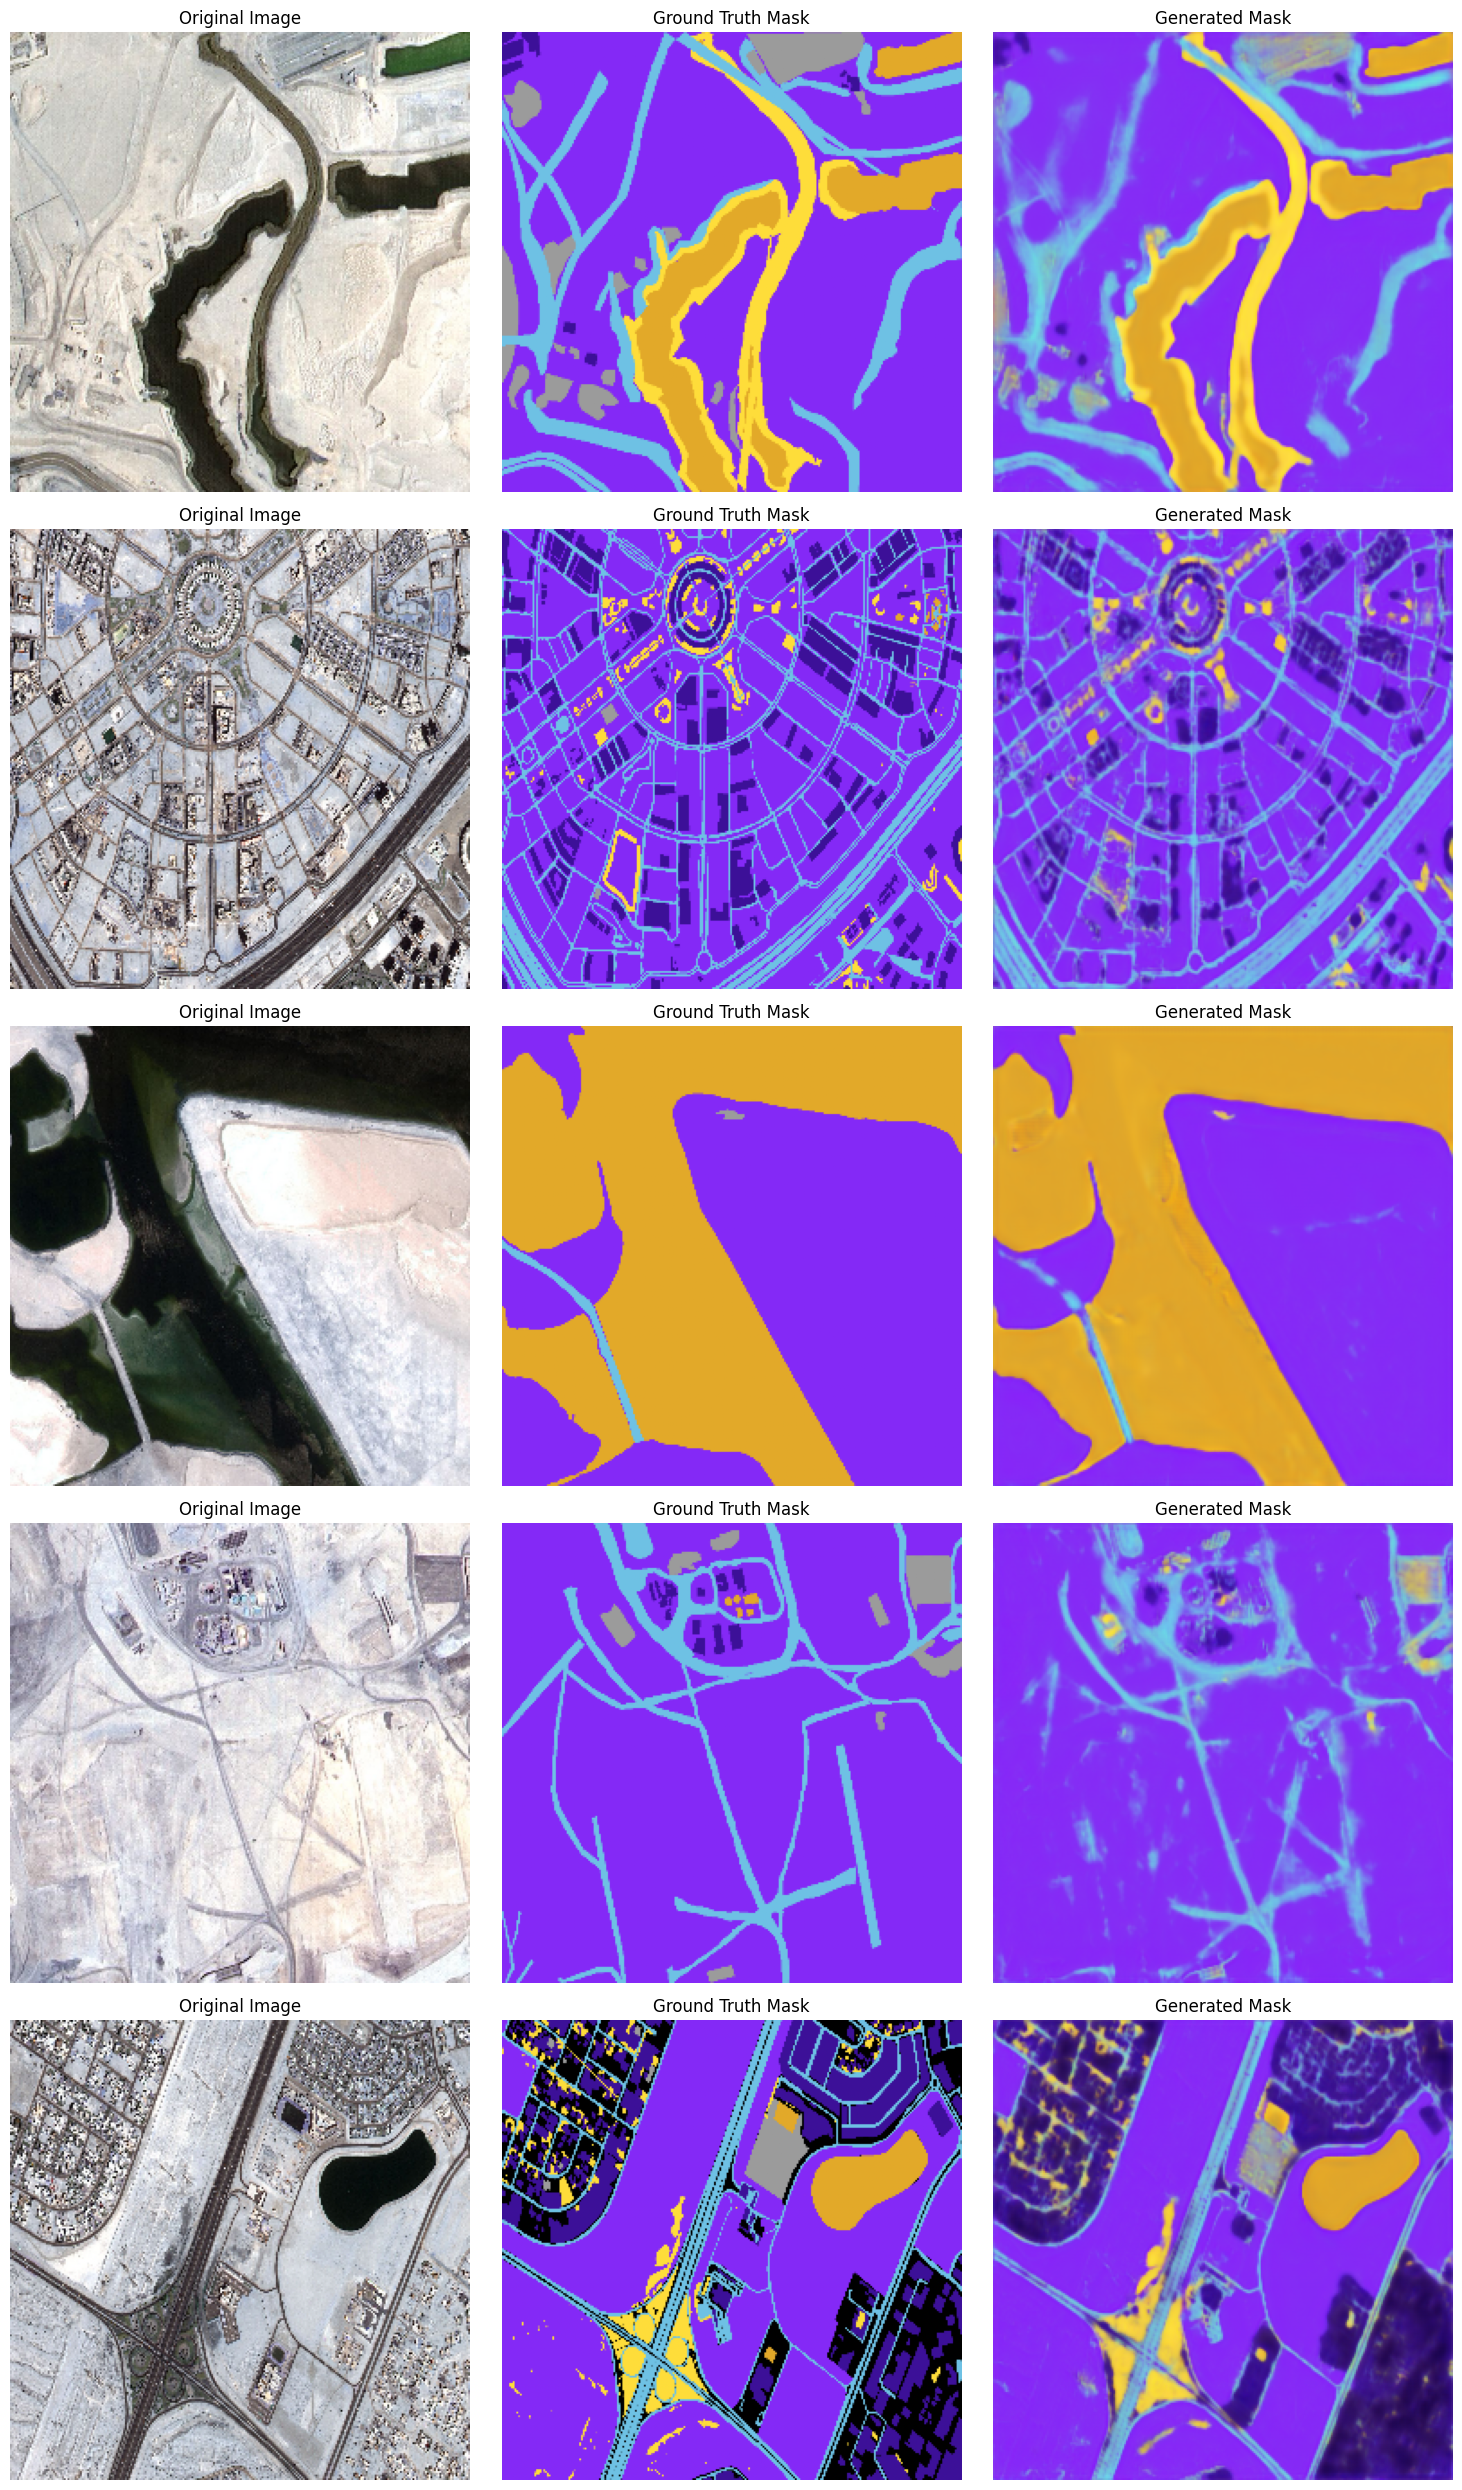

In [160]:
display_images(train_loader, model, 5)

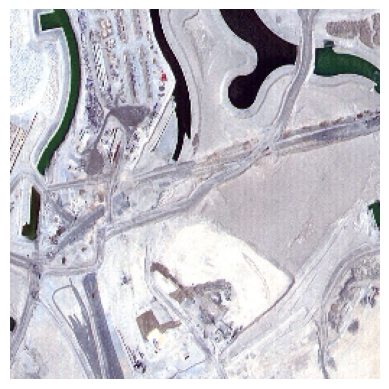

In [165]:
img = cv2.resize( cv2.cvtColor( cv2.imread("Tile 1_image_part_001.jpg"), cv2.COLOR_RGB2BGR ), target_shape ) / 255.0
# img = train_dataset[0][0].unsqueeze(0).cuda()

plt.axis('off')
plt.imshow(img)

In [166]:
img.shape

(256, 256, 3)

In [167]:
img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).cuda()
print(img.shape)


torch.Size([1, 3, 256, 256])


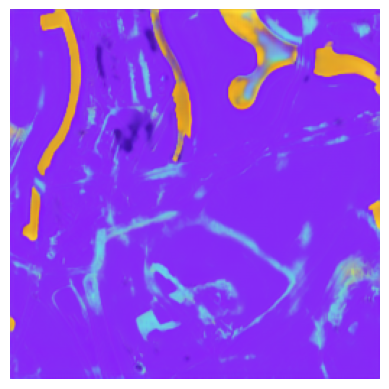

In [168]:

# Generate predictions
with torch.no_grad():
    output = model(img)

plt.axis('off')
plt.imshow(output[0].cpu().numpy().transpose(1, 2, 0))